In [ ]:
%load_ext autoreload
%autoreload 2

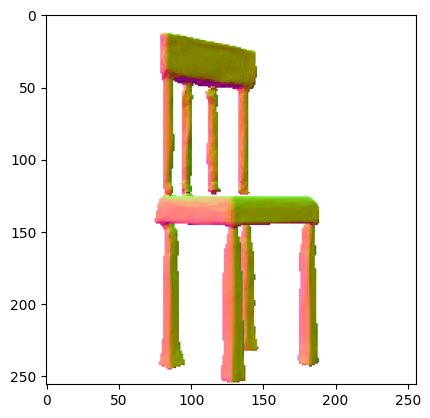

In [2]:
import cv2
import numpy as np
from lib.visualize.image import visualize_image
from lib.render.camera import Camera
from lib.optimize.latent import LatentOptimizer
import torch


sphere_eps = 3e-2
azim = 45
elev = -0
dist = 4

ckpt_path = "/home/borth/sketch2shape/checkpoints/deepsdf.ckpt"
camera = Camera(azim=azim, elev=elev, dist=dist, sphere_eps=sphere_eps)
points, rays, mask = camera.unit_sphere_intersection_rays()
model = LatentOptimizer(
    ckpt_path=ckpt_path,
    shininess=0.0,
    prior_idx=0,
    sphere_eps=sphere_eps,
).to("cuda:0")
surface_points, surface_mask = model.sphere_tracing(
    points=torch.tensor(points, device=model.device),
    rays=torch.tensor(rays, device=model.device),
    mask=torch.tensor(mask, device=model.device),
)
normals = model.render_normals(points=surface_points, mask=surface_mask)
normal_image = visualize_image(model.normal_to_image(normals, surface_mask))

In [ ]:
import matplotlib.pyplot as plt

min_points, surface_mask = model.sphere_tracing_min_sdf(
    points=points.to(device),
    rays=rays.to(device),
    mask=mask.to(device),
)
min_sdf = model.forward(points=min_points)
plt.imshow(model.to_image(min_sdf).detach().cpu().numpy())

In [ ]:
mesh = model.to_mesh(resolution=128)
mesh.show()

In [ ]:
import torch

light_position = torch.tensor([1, 1, 0], dtype=torch.float32, device=device)
surface_points, surface_mask = model.sphere_tracing(
    points=points.to(device),
    rays=rays.to(device),
    mask=mask.to(device),
)
image = model.render_image(
    points=surface_points,
    mask=surface_mask,
    camera_position=camera.camera_position().to(device),
    light_position=light_position,
)
gt_rendered_image = model.to_image(image, surface_mask)
_ = visualize_image(gt_rendered_image)

In [ ]:
(gt_rendered_image.detach().cpu().numpy() * 255).astype(np.uint8)

In [ ]:
from lib.data.preprocessing import image_to_sketch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dist = 4
for azim in tqdm(torch.arange(0, 360, 30), total=30):
    for elev in torch.arange(0, -60, -15):
        camera = Camera(azim=azim, elev=elev, dist=dist, sphere_eps=sphere_eps)
        points, rays, mask = camera.unit_sphere_intersection_rays()
        light_position = torch.tensor([1, 1, 0], dtype=torch.float32, device=device)
        surface_points, surface_mask = model.sphere_tracing(
            points=points.to(device),
            rays=rays.to(device),
            mask=mask.to(device),
        )
        normals = model.render_normals(points=surface_points, mask=surface_mask)
        normal_image = visualize_image(model.normal_to_image(normals, surface_mask))
        image = model.render_image(
            points=surface_points,
            mask=surface_mask,
            camera_position=camera.camera_position().to(device),
            light_position=light_position,
        )
        gt_rendered_image = model.to_image(image, surface_mask)
        _img = (gt_rendered_image.detach().cpu().numpy() * 255).astype(np.uint8)
        _sketch = image_to_sketch(
            [_img], t_lower=60, t_upper=100, aperture_size=3, L2gradient=True
        )[0]
        cv2.imwrite(f"temp/sketches/{azim}-{-elev}-{4}-sketch.png", _sketch)
        cv2.imwrite(
            f"temp/images/{azim}-{-elev}-{4}-image.png",
            cv2.cvtColor(
                gt_rendered_image.detach().cpu().numpy() * 255, cv2.COLOR_RGB2BGR
            ),
        )
        cv2.imwrite(
            f"temp/normals/{azim}-{-elev}-{4}-normal.png",
            cv2.cvtColor(normal_image * 255, cv2.COLOR_RGB2BGR),
        )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import Adam
from torch.nn.functional import normalize
from tqdm import tqdm
from pathlib import Path

path = Path("/home/borth/sketch2shape/data/siamese_chair_large")


def read_image(path: Path, device: str):
    transform = transforms.ToTensor()
    return transform(cv2.imread(str(path))).to(device)


gt_sketch_path = Path(path, "1a6f615e8b1b5ae4dbbc9440457e303e/sketches/00021.jpg")
gt_sketch = read_image(gt_sketch_path, device=device)
plt.imshow(gt_sketch.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

gt_rendered_image_path = Path(path, "fc4d15c15c56aa7baab4888e25356418/images/00021.jpg")
gt_rendered_image = read_image(gt_rendered_image_path, device=device)
plt.imshow(gt_rendered_image.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import Adam
from torch.nn.functional import normalize
from tqdm import tqdm

sketch = gt_sketch.clone().detach()
rendered_image = gt_rendered_image[0].clone().detach()
rendered_image.requires_grad = True
# rendered_image *= torch.randn_like(rendered_image)

optimizer = Adam([rendered_image], lr=1e-03)

for step in (pbar := tqdm(range(100))):
    optimizer.zero_grad()
    output = siamese.forward(
        {"sketch": sketch[None], "image": rendered_image.expand(3, 256, 256)[None]}
    )
    sketch_emb = normalize(output["sketch_emb"], dim=-1)
    image_emb = normalize(output["image_emb"], dim=-1)
    emb_loss = -(sketch_emb @ image_emb.T).sum() + 1
    # color_loss = torch.norm(rendered_image - rendered_image.mean(dim=0), p=1) * 0.1

    # loss = color_loss + emb_loss
    loss = emb_loss

    loss.backward()
    optimizer.step()

    # ensures that the image stays in correct values
    with torch.no_grad():
        for param in optimizer.param_groups[0]["params"]:
            param.clamp_(0, 1)

    pbar.set_postfix_str(f"{loss=:.3f}")
    # pbar.set_postfix_str(f"{loss=:.3f}, {emb_loss=:.3f}, {color_loss=:.3f}")
    # if step % 100 == 0:
    #     plt.imshow(rendered_image.permute(1, 2, 0).detach().cpu().numpy())
    #     plt.show()

plt.imshow(gt_sketch.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

plt.imshow(gt_rendered_image.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [ ]:
rendered_image = gt_rendered_image[0].clone().detach()
rendered_image.requires_grad = True

sketch = gt_sketch[0].clone().detach()
sketch.requires_grad = True

output = siamese.forward(
    {
        "sketch": sketch.expand(3, 256, 256)[None],
        "image": rendered_image.expand(3, 256, 256)[None],
    }
)
# sketch_emb = normalize(output["sketch_emb"], dim=-1)
# image_emb = normalize(output["image_emb"], dim=-1)
emb_loss = -(output["sketch_emb"] @ output["image_emb"].T).sum()
loss = emb_loss

grad_image = torch.autograd.grad(
    outputs=loss,
    inputs=rendered_image,
    grad_outputs=torch.ones_like(loss),
    retain_graph=True,
)[0]

grad_sketch = torch.autograd.grad(
    outputs=loss,
    inputs=sketch,
    grad_outputs=torch.ones_like(loss),
)[0]

plt.imshow(grad_image.detach().cpu().numpy())
plt.show()

plt.imshow(grad_sketch.detach().cpu().numpy())
plt.show()

In [ ]:
surface_mask = torch.ones_like(rendered_image)
surface_mask[rendered_image > 0.95] = 0
plt.imshow(surface_mask.detach().cpu().numpy())
plt.show()

In [ ]:
_grad_image = grad_image.clone()
plt.imshow(_grad_image.detach().cpu().numpy())
plt.show()

In [ ]:
grad_map = grad_image - grad_sketch
img = torch.ones_like(grad_sketch)
# img[] = 0
plt.imshow(grad_map.detach().cpu().numpy())
plt.show()

In [ ]:
img = torch.ones_like(grad_sketch)
img[torch.abs(grad_sketch) > 0.1] = 0
plt.imshow(img.detach().cpu().numpy())

In [ ]:
img = torch.ones_like(grad_image)
img[grad_image < -0.2] = 0
plt.imshow(img.detach().cpu().numpy())

In [ ]:
img = torch.ones_like(grad_image)
img[grad_image > 0.2] = 0
plt.imshow(img.detach().cpu().numpy())